# PyMOO NSGAII

In [27]:
import matplotlib.pyplot as plt

In [28]:
import pandas as pd
import numpy as np

In [29]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

In [30]:
def get_paths(x,distance_matrix):
    path = []
    for i in range(len(x)):
        x_row = x[i]
        path.append([[x_row[j],x_row[j+1]] for j in range(len(x_row)-1)])    
    path = np.array(path)
    return path

In [31]:
def get_travelling_distance(distance_matrix, path, n_pop):
    distance = []
    for i in range(n_pop):
        distance_row = []
        for j in range(len(path[i])):
            path_ij = path[i,j]
            distance_row.append(distance_matrix[path_ij[0],path_ij[1]])
        distance.append(distance_row)
    return np.array(distance)


## Check crossover and mutation distribution

### Crossover

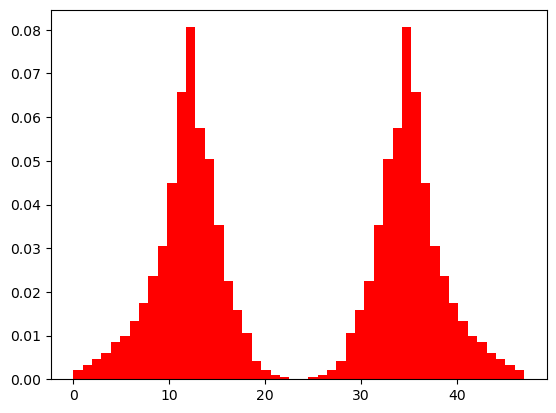

In [32]:
from pymoo.core.individual import Individual
from pymoo.core.problem import Problem

def show(eta_cross):
    problem = Problem(n_var=1, xl=0, xu=47)

    a, b = Individual(X=np.array([12])), Individual(X=np.array([35]))

    parents = [[a, b] for _ in range(5000)]

    off = SBX(prob=1.0, prob_var=1.0, eta=eta_cross, repair=RoundingRepair(), vtype=float).do(problem, parents)
    Xp = off.get("X")

    plt.hist(Xp, range=(0, 47), bins=48, density=True, color="red")
    plt.show()


show(3)

### Mutation

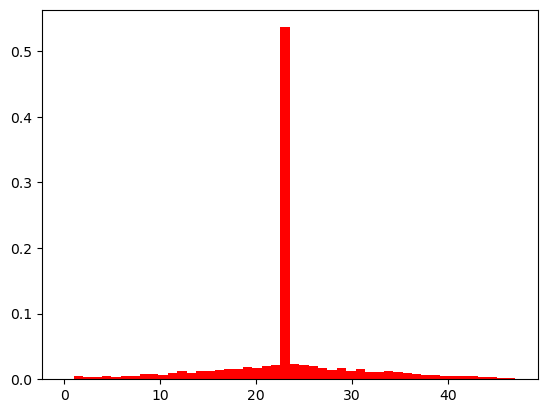

In [33]:
from pymoo.core.population import Population

def show(eta_mut):
    problem = Problem(n_var=1, xl=0, xu=47)

    X = np.full((5000, 1), 23)
    pop = Population.new(X=X)

    mutation = PM(prob=1.0, eta=eta_mut, repair=RoundingRepair())

    off = mutation(problem, pop)
    Xp = off.get("X")

    plt.hist(Xp, range=(0, 47), bins=48, density=True, color="red")
    plt.show()


show(3)

## Perform GA

In [34]:
class CustomPermutationProblem(Problem):
    def __init__(self, max_gene,distance_matrix, max_distance,ratings):
        super().__init__(
            n_var=max_gene,
            n_obj=2,  # Number of objectives
            n_constr=1,  # Number of constraints
            xl=0,  # Lower bounds for variables
            xu=len(distance_matrix) - 1,  # Upper bounds for variables
        )

        self.distance_matrix = distance_matrix
        self.max_distance = max_distance
        self.ratings = ratings
 
    def _evaluate(self, x, out, *args, **kwargs):
        # permutation with replacement problem

        # get paths from individuals -> pair the next nearest genes
        path = get_paths(x,self.distance_matrix)

        #calculate travelling distances from paths
        traveling_distance = get_travelling_distance(self.distance_matrix,path, len(x))
        total_traveling_distance = np.sum(traveling_distance, axis = 1)
        
        num_unique_places = np.array([len(np.unique(x[i])) for i in range(len(x))])

        # get average ratings
        avg_rating = []
        for i in range(len(x)):
            places_in_route = np.unique(x[i])
            avg_rating.append(np.average([self.ratings[j] for j in places_in_route]))

        # Objectives
        f1 = -num_unique_places # number of unique places went
        f2 = -np.array(avg_rating) # average rating

        # Constraints
        if self.max_distance == 'no limit':
            g1 = -total_traveling_distance
        else:
            g1 = total_traveling_distance - self.max_distance # distance limit


        out["F"] = np.column_stack([f1,f2]) # Set the objective values
        out["G"] = np.column_stack([g1])

        

In [35]:
df = pd.read_csv("W://DS//Optimization//Term Project//data.csv")

In [36]:
df.head()

,Unnamed: 0,No,name,type,rating,count,code location,link,Gene code,lat_long
0,0,1,Taste Cafe,NaN,4.6,457,QXW7+36 เทศบาลนครเชียงใหม่ อำเภอเมืองเชียงใหม่...,https://maps.app.goo.gl/KS5jRncaRgY9c8Vs5,a1,"(18.7951875, 98.9630625)"
1,1,2,yesterday cafe',NaN,4.4,135,QXW8+QF เทศบาลนครเชียงใหม่ อำเภอเมืองเชียงใหม่...,https://maps.app.goo.gl/iWJY4rcZj5ot4b1b6,a2,"(18.7969375, 98.96618749999999)"
2,2,3,Nine One Coffee,NaN,4.7,439,QXW8+QQ เทศบาลนครเชียงใหม่ อำเภอเมืองเชียงใหม่...,https://maps.app.goo.gl/aMEKVtvdbR8n1xMCA,b1,"(18.7969375, 98.9669375)"
3,3,4,Morestto,NaN,4.7,297,QXX7+WJ เทศบาลนครเชียงใหม่ อำเภอเมืองเชียงใหม่...,https://maps.app.goo.gl/t4a7mG1SLNfjDEAh8,b2,"(18.7998125, 98.9640625)"
4,4,5,Ristr8to Original,NaN,4.7,644,QXX8+MV เทศบาลนครเชียงใหม่ อำเภอเมืองเชียงใหม่...,https://maps.app.goo.gl/WatnZ6gn7NCcAkgk7,c1,"(18.7991875, 98.9671875)"


In [37]:
'''distance_matrix = np.array([[ 0,  20,  40,  60],
                            [80,  0,  70,  10],
                            [30, 90,  0,  50],
                            [70, 40,  10,  0]])'''

#distance_matrix = pd.read_csv("W://DS//Optimization//Term Project//distance_matrix.csv", header =None).values
distance_matrix = pd.read_csv("W://DS//Optimization//Term Project//duration_matrix.csv", header =None).values
is_duration = True

In [38]:
# this is for output naming for export purpose
if is_duration:
    matrix_type = "max_duration"
    unit = "seconds"
else:
    matrix_type = "max_distance"
    unit = "metres"

In [39]:
distance_matrix.shape

(48, 48)

In [40]:
#ratings = np.array([ 4,  4,  2,  3])

ratings = df['rating'].values


In [41]:
ratings.shape

(48,)

In [42]:
# set max_distance/duration here
max_distance = 300
if max_distance == 'no limit':
    unit = ''
set = 0
max_genes = [8,16,24,32,40,48]

In [43]:
# Define the problem
problem = CustomPermutationProblem(max_genes[set],distance_matrix,max_distance,ratings)

# Define the optimization algorithm (genetic algorithm in this case)
algorithm = NSGA2(
    pop_size=200,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=1.0, eta=3, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=True)

# Optimize the problem
result = minimize(
    problem,
    algorithm,
    ("n_gen", 2000),  # Number of generations
    seed=1,
    verbose=True,
    save_history=True
)


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      1 |  1.707000E+03 |  3.731680E+03 |             - |             -
     2 |      400 |      1 |  1.487000E+03 |  3.027345E+03 |             - |             -
     3 |      600 |      1 |  1.300000E+03 |  2.661780E+03 |             - |             -
     4 |      800 |      1 |  1.300000E+03 |  2.404560E+03 |             - |             -
     5 |     1000 |      1 |  9.950000E+02 |  2.164365E+03 |             - |             -
     6 |     1200 |      1 |  6.990000E+02 |  1.931860E+03 |             - |             -
     7 |     1400 |      1 |  5.540000E+02 |  1.729275E+03 |             - |             -
     8 |     1600 |      1 |  3.420000E+02 |  1.570695E+03 |             - |             -
     9 |     1800 |      1 |  3.420000E+02 |  1.398520E+03 |             - |             -
    10 |     2000 |      1 |  3.420000E+02 |  1.223240E+03 |             - |             -

In [44]:
from pymoo.visualization.scatter import Scatter

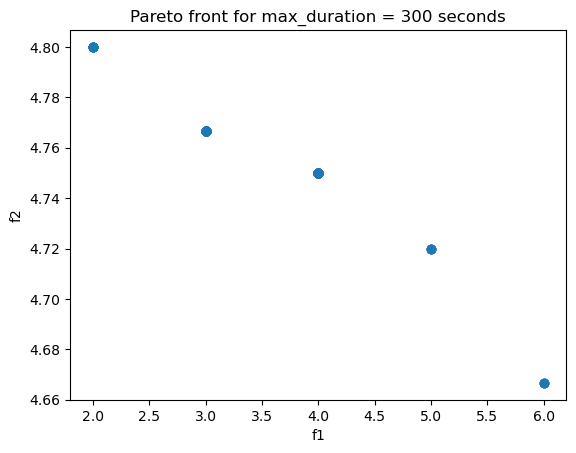

In [45]:
plt.scatter(-result.F[:,0],-result.F[:,1])
title = "Pareto front for "+matrix_type+" = "+str(max_distance)+" "+str(unit)
plt.title(title)
plt.xlabel('f1')
plt.ylabel('f2')
if is_duration:
    constraint_value = ('0'*(4-len(str(max_distance))))+str(max_distance)
else:
    constraint_value = str(max_distance)
plt.savefig("output//pareto fronts//pareto_front_"+matrix_type+"_"+constraint_value+str(unit)+"_"+str(set+1)+".pdf")
plt.show()

## Convergence

In [46]:
hist = result.history
X, F = result.opt.get("X", "F")

In [47]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

### Constraint Satisfaction

In [48]:
k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

At least one feasible solution in Generation 16 after 3400 evaluations.


Whole population feasible in Generation 38 after 7800 evaluations.


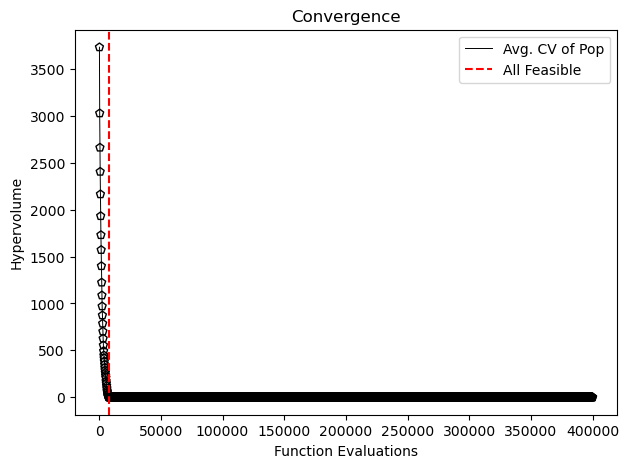

In [49]:
# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.savefig("output//convergence//cv//cv_"+matrix_type+"_"+constraint_value+str(unit)+"_"+str(set+1)+".pdf")
plt.show()

### Hyper Volume

In [50]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

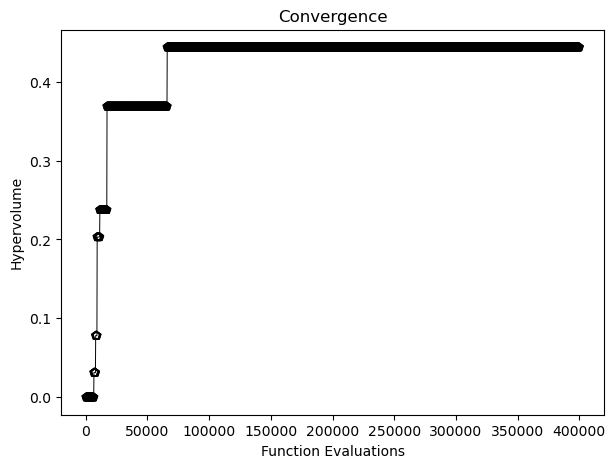

In [51]:
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array([1, 1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.savefig("output//convergence//pareto front hypervolume test//hypervolume_"+matrix_type+"_"+constraint_value+str(unit)+"_"+str(set+1)+".pdf")
plt.show()

## Extract solutions and its objective values

In [52]:
pd.DataFrame(-F).to_csv("output//objective function values//objective_function_values_"+matrix_type+"_"+constraint_value+str(unit)+"_"+str(set+1)+".csv",header=False, index=False)
pd.DataFrame(X).to_csv("output//solutions//solutions_"+matrix_type+"_"+constraint_value+str(unit)+"_"+str(set+1)+".csv",header=False, index=False)